In [1]:
%run '../definitions.ipynb'

In [2]:
def simulate_photon_times(n_photons, t1, t3, fs, tts):
    times = np.zeros(n_photons)
    n_singlets = np.random.binomial(n=n_photons, p=fs)
    times += np.concatenate([
        np.random.exponential(t1, n_singlets),
        np.random.exponential(t3, n_photons - n_singlets)
    ])
    np.random.shuffle(times)
    times += np.random.normal(0, tts, size=n_photons)
    return times
    

In [43]:
def build_likelihood_function(n_photons, t1, t3, fs, tts, hist_range, hist_bins, 
                              offset = None, plot=False, ):
    if offset is None:
        offset = 1 / n_photons
    times = simulate_photon_times(n_photons, t1, t3, fs, tts)
    vals, edges  = np.histogram(times, range = hist_range, bins = hist_bins, normed=True)
    vals = np.max([vals, np.ones(len(vals)) * offset], axis=0)
    centers = 0.5 * (edges[:-1] + edges[1:])
    def f(x):
        return np.interp(x, centers, vals)
    def negloglikelihood(x):
        return np.interp(x, centers, -np.log(vals))
    
    if plot:
        x_plot = centers
        plt.hist(times, range = hist_range, bins = hist_bins, normed=True, histtype = 'step')
        plt.plot(centers, f(centers))
        plt.yscale('log')
    return negloglikelihood

In [4]:
def simulate_s1_times(n_photons, t1, t3, fs, tts, photons_per_s1):
    times = simulate_photon_times(n_photons, t1, t3, fs, tts)
    n_s1s = int(np.floor(n_photons / photons_per_s1))
    times = times[:(n_s1s * photons_per_s1)]
    s1_times = np.split(times, n_s1s)
    return np.array(s1_times)

In [5]:
from tqdm import tqdm
def max_likelihood(s1_times, f):
    shifts = []
    likes = []
    for s1 in tqdm(s1_times):
        optres = scipy.optimize.minimize(lambda x: np.sum(f(s1 + x)), 0.)
        shifts.append(optres.x[0])
        likes.append(optres.fun)
    return likes, shifts

In [40]:
def likelihood_ratio(s1s, f_er, f_nr):
    er_likelihood = max_likelihood(s1s, f_er)
    nr_likelihood = max_likelihood(s1s, f_nr)
    LR = np.array(nr_likelihood[0]) / np.array(er_likelihood[0])
    return LR

## Build likelihoods

In [98]:
nr_params = dict(
    fs = 0.4, 
    t3 = 24,
    t1 = 2.,
    tts = 0.1#1.75,
)

er_params = dict(
    fs = 0.18,
    t3 = 24,
    t1 = 2.,
    tts = 0.1 # 1.75,
)

In [99]:
f_er = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000, **nr_params)
f_nr = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000, **er_params)


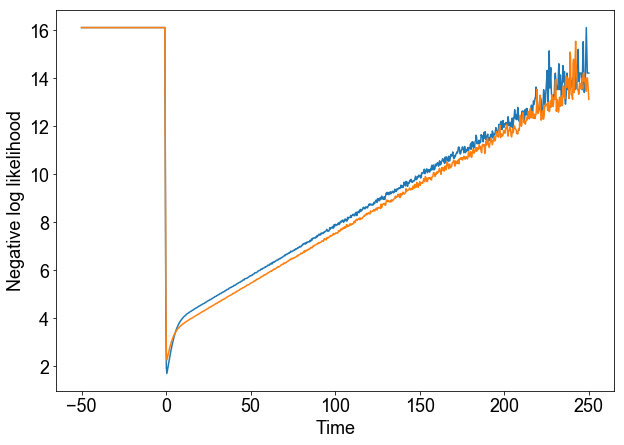

In [100]:
t = np.linspace(-50, 250, 1000)
plt.plot(t, f_er(t))
plt.plot(t, f_nr(t))
plt.xlabel('Time')
plt.ylabel('Negative log likelihood')

## Build ER and NR s1 samples

In [101]:
photons_per_s1 = 30 # photons
n_s1s = 500
n_ph = n_s1s * photons_per_s1

In [102]:
s1s_er = simulate_s1_times(n_ph, photons_per_s1 = photons_per_s1, **er_params)
s1s_nr = simulate_s1_times(n_ph, photons_per_s1 = photons_per_s1, **nr_params)

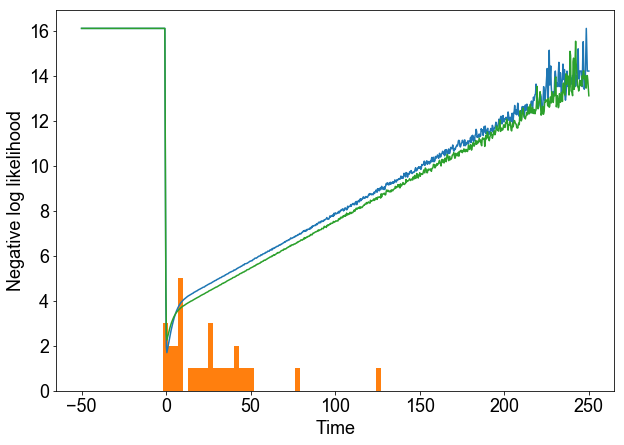

In [103]:
t = np.linspace(-50, 250, 1000)
plt.plot(t, f_er(t))
plt.hist(s1s_er[0], bins=100, range=(-50, 250))
plt.plot(t, f_nr(t))
plt.xlabel('Time')
plt.ylabel('Negative log likelihood')
plt.show()

In [104]:
nr_lr = likelihood_ratio(s1s_nr, f_er, f_nr)
er_lr = likelihood_ratio(s1s_er, f_er, f_nr)

100%|██████████| 500/500 [00:09<00:00, 50.16it/s]


In [107]:
off = 0.1

scan_values = np.linspace(1 - off, 1 + off, 200)
nr_acc = np.array([np.sum(nr_lr >= discval) / len(nr_lr) for discval in scan_values])
er_acc = np.array([np.sum(er_lr >= discval) / len(er_lr) for discval in scan_values])

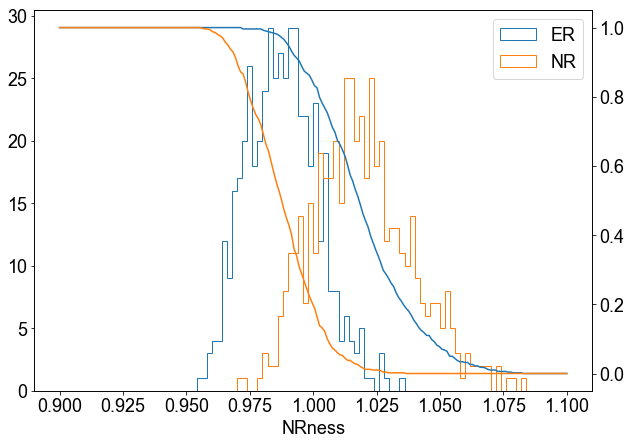

In [108]:
plt.hist(er_lr, 
         bins=100, histtype='step', label='ER', range=(1 - off, 1+ off))
plt.hist(nr_lr,
         bins=100, histtype='step', label='NR', range=(1 - off, 1+ off))
plt.xlabel('NRness')
plt.legend()
plt.twinx()
plt.plot(scan_values, nr_acc)
plt.plot(scan_values, er_acc)

plt.show()

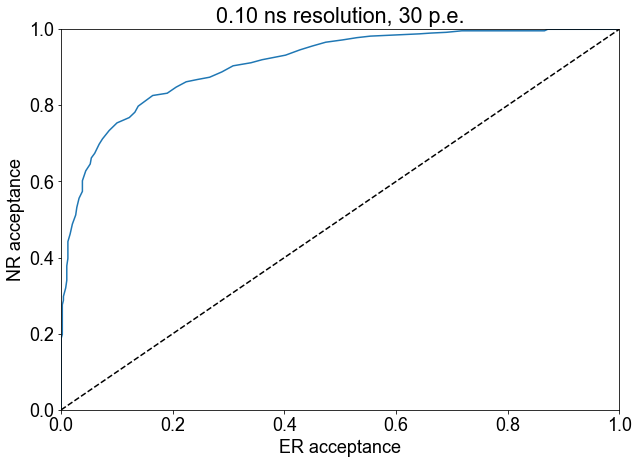

In [109]:
plt.plot(er_acc, nr_acc)
plt.plot([0,1], [0,1],ls='--', color='black')
plt.xlabel('ER acceptance')
plt.ylabel('NR acceptance')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("%.2f ns resolution, %d p.e." % (er_params['tts'], photons_per_s1))
plt.show()

In [ ]:
max_likelihood(s1s, f_er)

100%|██████████| 100/100 [00:03<00:00, 30.19it/s]


(array([  2.,   8.,  17.,  18.,  18.,  19.,   9.,   7.,   1.,   1.]),
 array([ 1.03056096,  1.03318532,  1.03580967,  1.03843403,  1.04105839,
         1.04368275,  1.0463071 ,  1.04893146,  1.05155582,  1.05418018,
         1.05680453]),
 <a list of 10 Patch objects>)

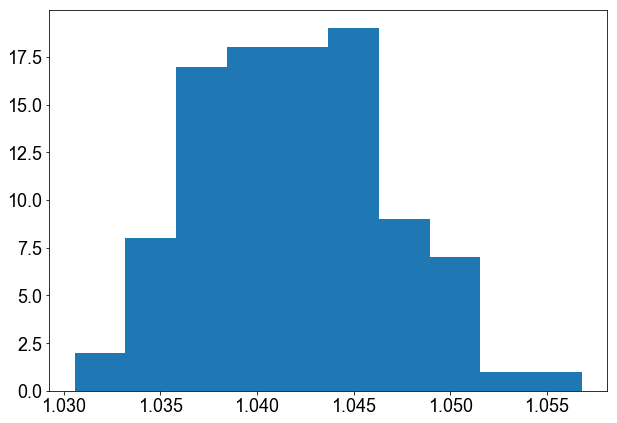

In [39]:
plt.hist(er_lr)

What? What? Am I smearing twice?

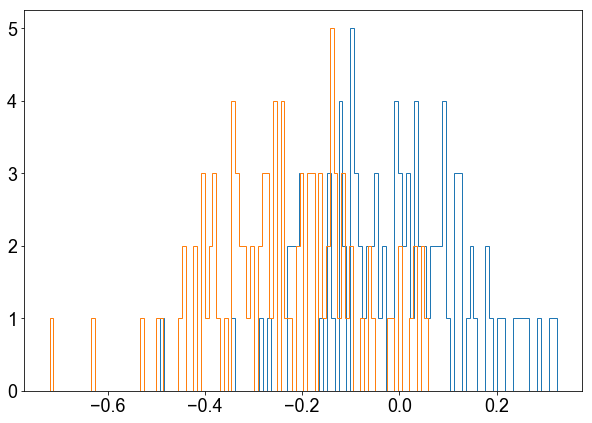

In [151]:
plt.hist(s1s_er_erlikelihood[1], bins=100, histtype='step')
plt.hist(s1s_er_nrlikelihood[1], bins=100, histtype='step')
plt.show()

In [108]:
likes, shifts = max_likelihood(s1_times, f)

100%|██████████| 500/500 [00:08<00:00, 57.05it/s]


(array([   3.,   22.,   61.,   89.,  127.,   84.,   68.,   30.,   14.,    2.]),
 array([ 68.3817801 ,  71.06925792,  73.75673575,  76.44421358,
         79.13169141,  81.81916924,  84.50664707,  87.19412489,
         89.88160272,  92.56908055,  95.25655838]),
 <a list of 10 Patch objects>)

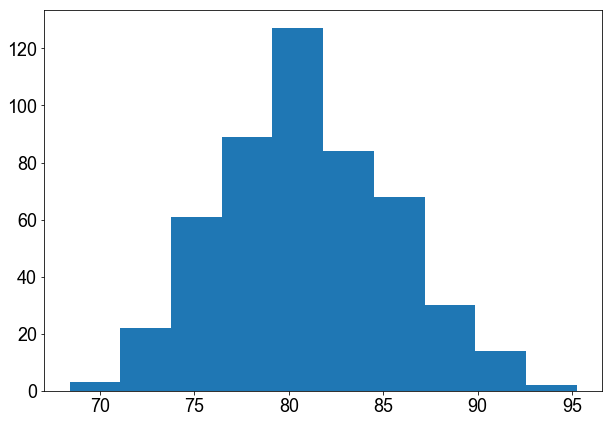

In [110]:
plt.hist(likes)

In [49]:
np.max([[1,2,3], np.ones(3) * 2], axis=0)

array([ 2.,  2.,  3.])